In [21]:
import tensorflow as tf
import os

graph_def = tf.compat.v1.GraphDef()
labels = []

# These are set to the default names from exported models, update as needed.
filename = "model.pb"
labels_filename = "labels.txt"

# Import the TF graph
with tf.io.gfile.GFile(filename, 'rb') as f:
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

# Create a list of labels.
with open(labels_filename, 'rt') as lf:
    for l in lf:
        labels.append(l.strip())


In [22]:
def convert_to_opencv(image):
    # RGB -> BGR conversion is performed as well.
    image = image.convert('RGB')
    r,g,b = np.array(image).T
    opencv_image = np.array([b,g,r]).transpose()
    return opencv_image

def crop_center(img,cropx,cropy):
    h, w = img.shape[:2]
    startx = w//2-(cropx//2)
    starty = h//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx]

def resize_down_to_1600_max_dim(image):
    h, w = image.shape[:2]
    if (h < 1600 and w < 1600):
        return image

    new_size = (1600 * w // h, 1600) if (h > w) else (1600, 1600 * h // w)
    return cv2.resize(image, new_size, interpolation = cv2.INTER_LINEAR)

def resize_to_256_square(image):
    h, w = image.shape[:2]
    return cv2.resize(image, (256, 256), interpolation = cv2.INTER_LINEAR)

def update_orientation(image):
    exif_orientation_tag = 0x0112
    if hasattr(image, '_getexif'):
        exif = image._getexif()
        if (exif != None and exif_orientation_tag in exif):
            orientation = exif.get(exif_orientation_tag, 1)
            # orientation is 1 based, shift to zero based and flip/transpose based on 0-based values
            orientation -= 1
            if orientation >= 4:
                image = image.transpose(Image.TRANSPOSE)
            if orientation == 2 or orientation == 3 or orientation == 6 or orientation == 7:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
            if orientation == 1 or orientation == 2 or orientation == 5 or orientation == 6:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return image

In [23]:
from PIL import Image
import numpy as np
import cv2

# Load from a file
imageFile = "test (1).jpg"
img = "test (1).jpg"
image = Image.open(imageFile)
img = Image.open(img)

# Update orientation based on EXIF tags, if the file has orientation info.
image = update_orientation(image)

# Convert to OpenCV format
image = convert_to_opencv(image)

In [24]:
# If the image has either w or h greater than 1600 we resize it down respecting
# aspect ratio such that the largest dimension is 1600
image = resize_down_to_1600_max_dim(image)

In [25]:
# We next get the largest center square
h, w = image.shape[:2]
min_dim = min(w,h)
max_square_image = crop_center(image, min_dim, min_dim)

In [26]:
# Resize that square down to 256x256
augmented_image = resize_to_256_square(max_square_image)

In [27]:
# Get the input size of the model
with tf.compat.v1.Session() as sess:
    input_tensor_shape = sess.graph.get_tensor_by_name('Placeholder:0').shape.as_list()
network_input_size = input_tensor_shape[1]

# Crop the center for the specified network_input_Size
augmented_image = crop_center(augmented_image, network_input_size, network_input_size)

In [28]:
# These names are part of the model and cannot be changed.
output_layer = 'loss:0'
input_node = 'Placeholder:0'

with tf.compat.v1.Session() as sess:
    try:
        prob_tensor = sess.graph.get_tensor_by_name(output_layer)
        predictions, = sess.run(prob_tensor, {input_node: [augmented_image] })
    except KeyError:
        print ("Couldn't find classification output layer: " + output_layer + ".")
        print ("Verify this a model exported from an Object Detection project.")
        exit(-1)

In [37]:
# Print the highest probability label
     
    highest_probability_index = np.argmax(predictions)
    print('Classified as: ' + labels[highest_probability_index])
    print()

    # Or you can print out all of the results mapping labels to probabilities.
    label_index = 0
    for p in predictions:
        if p>=0.6:
            truncated_probablity = np.float64(np.round(p,8))
            print (labels[label_index], truncated_probablity)
        label_index += 1

Classified as: Uttapam

Kachori 0.6350609660148621
Uttapam 0.8488888740539551


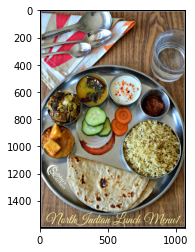

In [30]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [33]:
print(labels)
print(predictions)

['Dhokla', 'Jalebi', 'Kachori', 'Masala Tea', 'Omelette', 'Poha', 'Uttapam']
[0.07847903 0.00633629 0.63506097 0.17322576 0.00573819 0.0567332
 0.8488889 ]
